In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.lorenz96 import Lorenz96Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## Model

Periodic domain $u \in [0,L)$ and $N$ equally spaced grid-points $u_j = j \Delta$, $\Delta = \frac{L}{N}$, with system governed by ODEs

\begin{align}
  \frac{\mathrm{d} z_j}{\mathrm{d} t} = -\frac{z_{j\ominus 1} z_{j\oplus 1} - z_{j\ominus 2} z_{j\ominus 1}}{3 \Delta} - z_j + f
  \quad \forall j \in \{1 \dots N\}
\end{align}

with $\oplus$ and $\ominus$ indicating addition / subtraction modulo $N_x$ respectively. Model due to Lorenz (1996):

> Lorenz, Edward (1996). "Predictability – A problem partly solved". 
> Seminar on Predictability, Vol. I, ECMWF.

Here we use $\Delta = \frac{1}{3}$, $N = 40$, $f= 8$.

In [2]:
n_steps = 200
seed = 20171027
rng = np.random.RandomState(seed)
observation_func = lambda z, t: z
state_noise_std = 0.1
obser_noise_std = 2.
model = Lorenz96Model(
    rng=rng, state_noise_std=state_noise_std, obser_noise_std=obser_noise_std,
    observation_func=observation_func)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

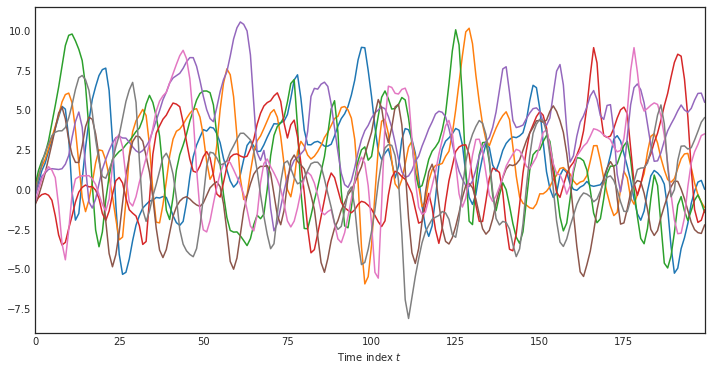

In [4]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[:, ::5])
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

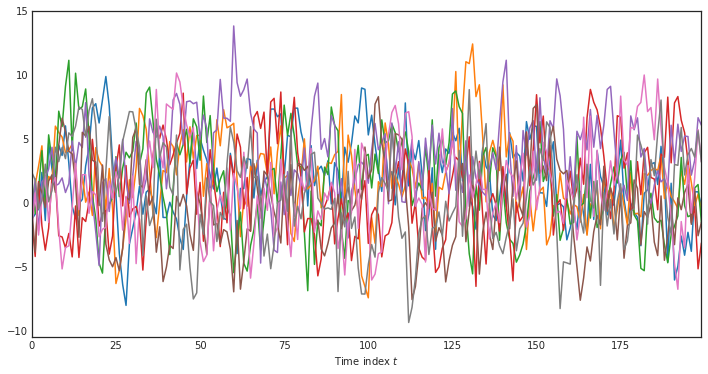

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference[:, ::5])
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

## Infer state from observations

### Ensemble Kalman filter (perturbed observations)

In [6]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [7]:
%%time
results_enkf = enkf.filter(x_reference, 500, return_particles=True)

CPU times: user 33 s, sys: 248 ms, total: 33.3 s
Wall time: 8.91 s


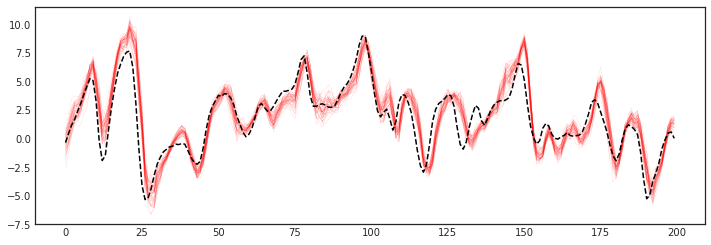

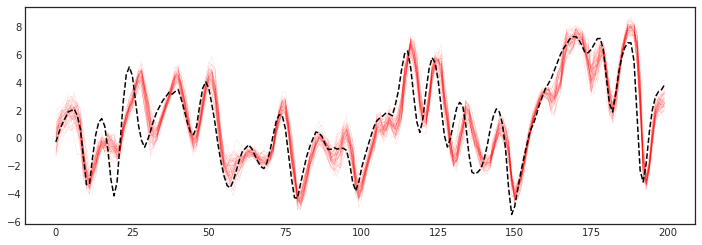

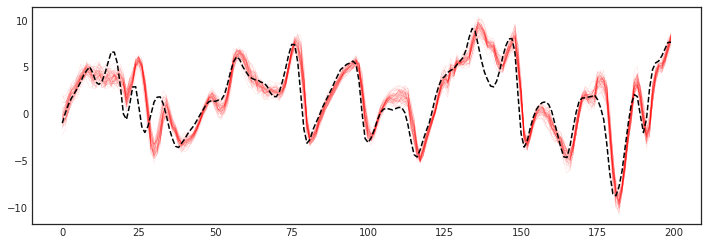

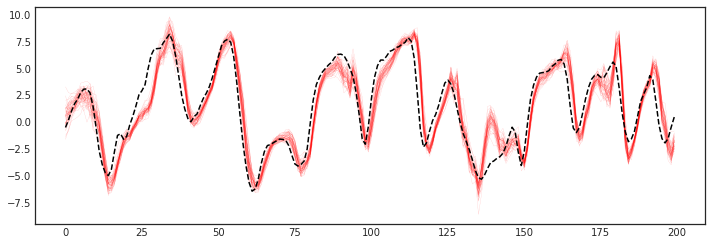

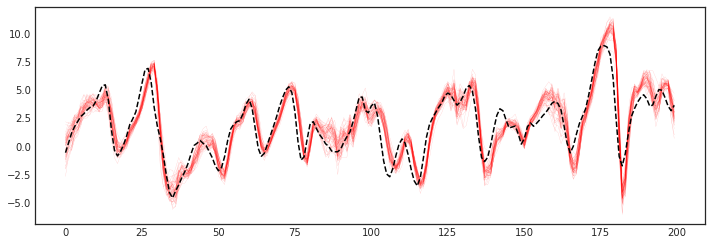

In [8]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_enkf['z_particles_seq'][:, ::10, i], 'r-', 
                lw=0.25, alpha=0.25, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

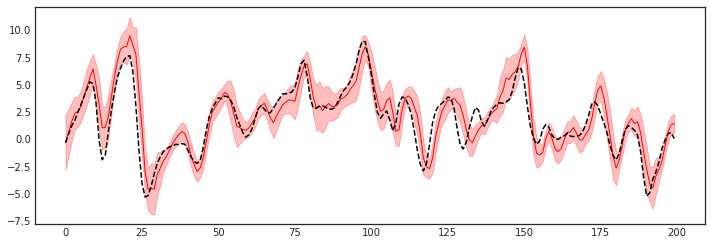

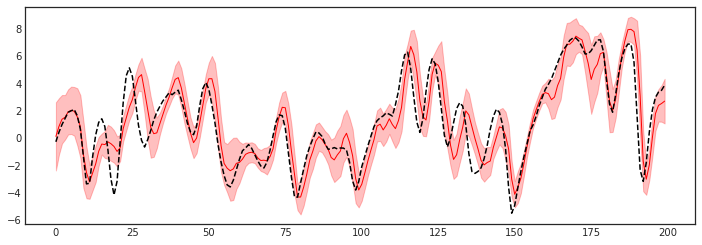

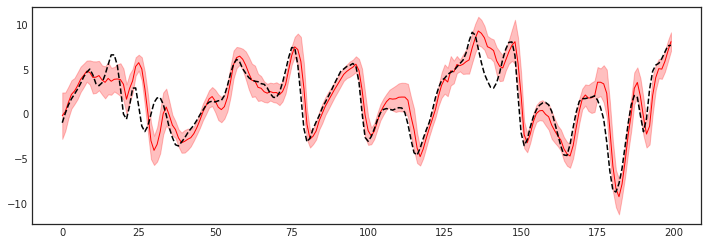

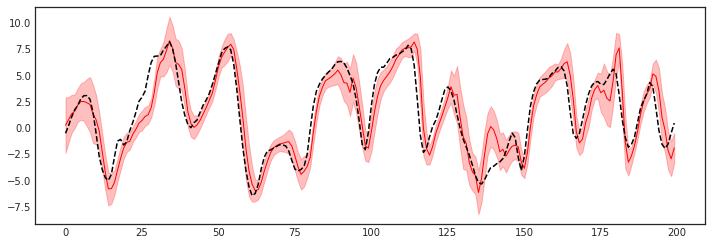

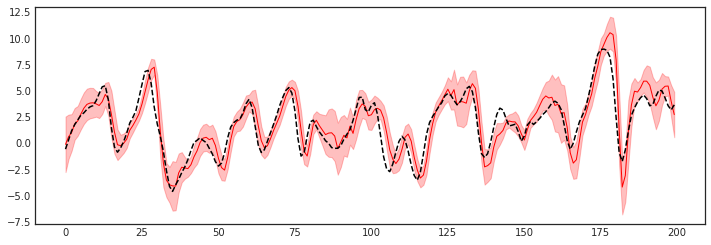

In [9]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_enkf['z_mean_seq'][:, i], 'r-', lw=1, label='EnKF')
    _ = ax.fill_between(
        np.arange(n_steps),
        results_enkf['z_mean_seq'][:, i] - 3 * results_enkf['z_std_seq'][:, i],
        results_enkf['z_mean_seq'][:, i] + 3 * results_enkf['z_std_seq'][:, i],
        alpha=0.25, color='r'
    )
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Local ensemble transform Kalman filter

In [10]:
state_grid_coords = np.arange(model.dim_z)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = np.arange(model.dim_z)[:, None]
localisation_radius = 4
localisation_func = da.PeriodicLocalisationFunction(
    state_grid_coords, state_grid_shape, obser_grid_coords, 
    localisation_radius, use_cache=True
)

In [11]:
letkf = da.LocalEnsembleTransformKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_z), model.dim_z, localisation_func, 1.15, rng
)

In [12]:
%%time
results_letkf = letkf.filter(x_reference, 10, return_particles=True)

CPU times: user 9.18 s, sys: 200 ms, total: 9.38 s
Wall time: 2.49 s


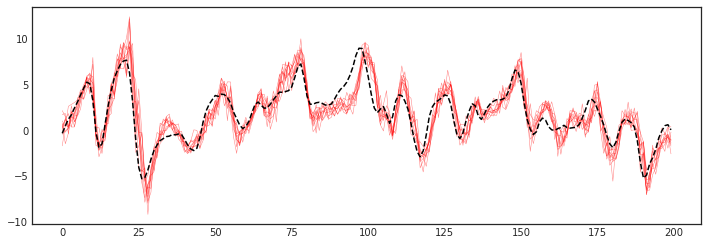

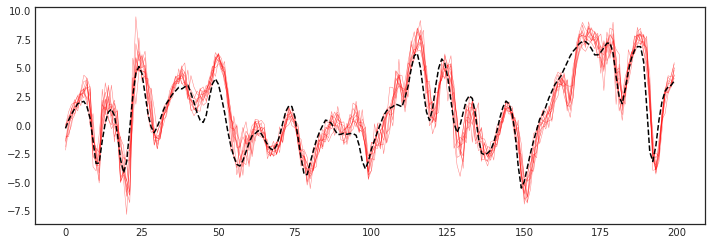

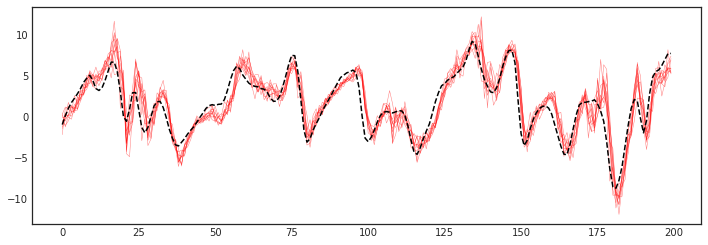

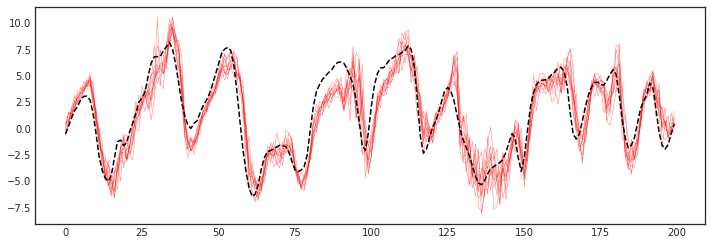

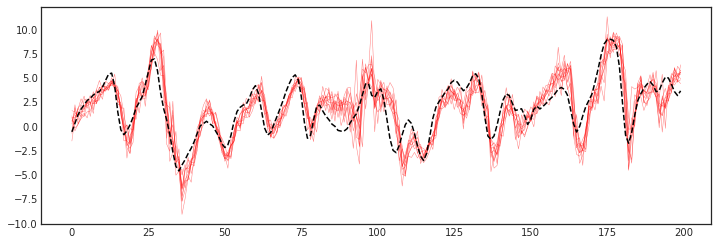

In [13]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_letkf['z_particles_seq'][:, :, i], 'r-', 
                lw=0.5, alpha=0.5)
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

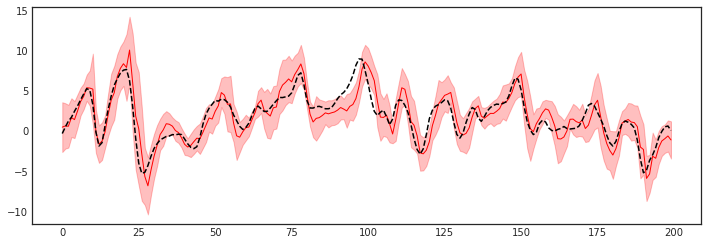

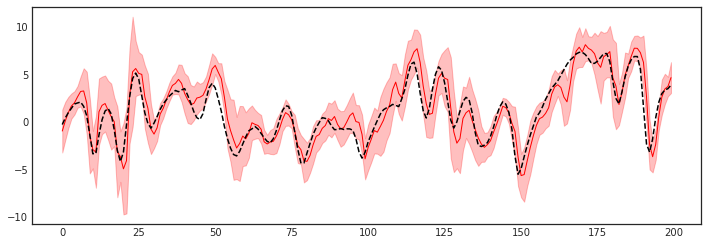

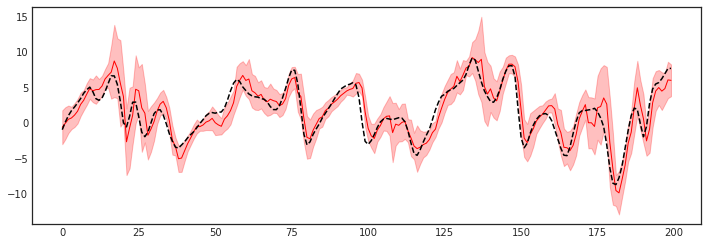

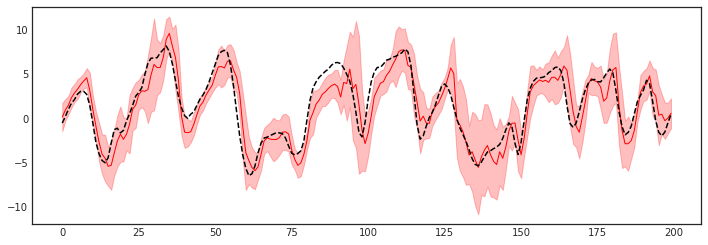

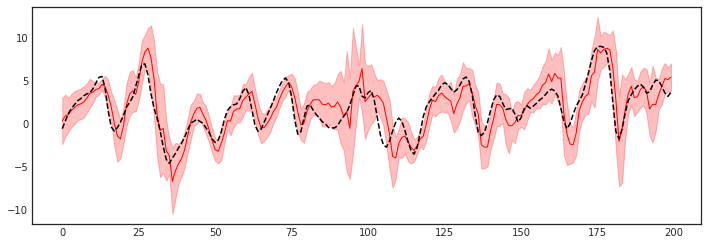

In [14]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_letkf['z_mean_seq'][:, i], 'r-', lw=1)
    _ = ax.fill_between(
        np.arange(n_steps),
        results_letkf['z_mean_seq'][:, i] - 3 * results_letkf['z_std_seq'][:, i],
        results_letkf['z_mean_seq'][:, i] + 3 * results_letkf['z_std_seq'][:, i],
        alpha=0.25, color='r'
    )
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Bootstrap particle filter

In [15]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [16]:
%%time
results_bspf = bspf.filter(x_reference, 500, return_particles=True)

CPU times: user 29.8 s, sys: 168 ms, total: 29.9 s
Wall time: 8.16 s


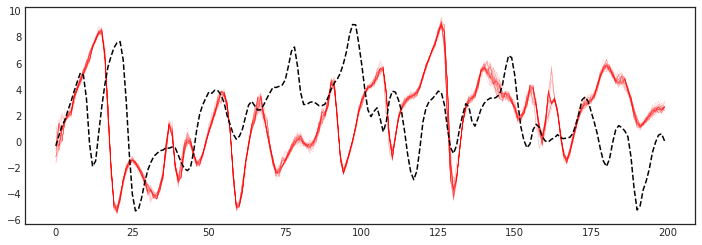

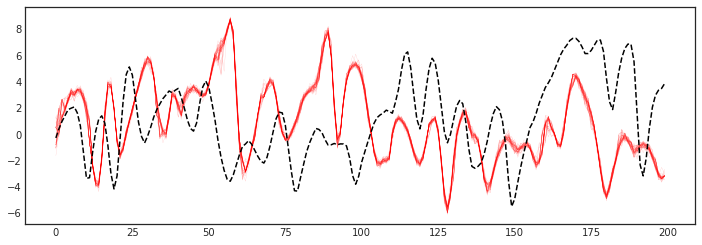

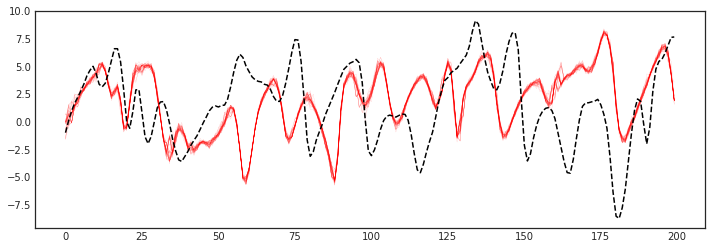

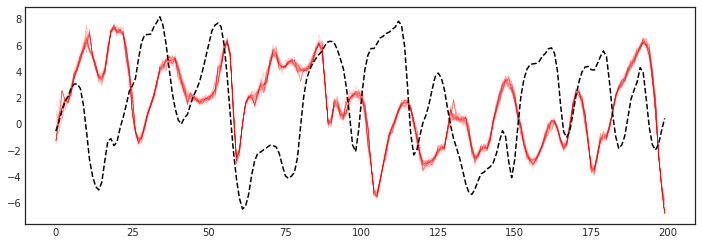

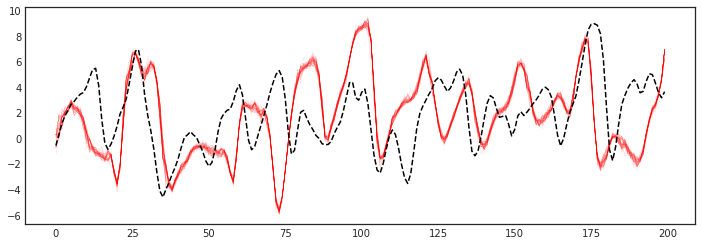

In [17]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_bspf['z_particles_seq'][:, ::10, i], 'r-', lw=0.25, alpha=0.25)
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

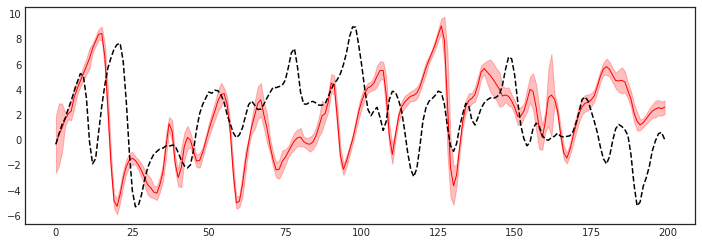

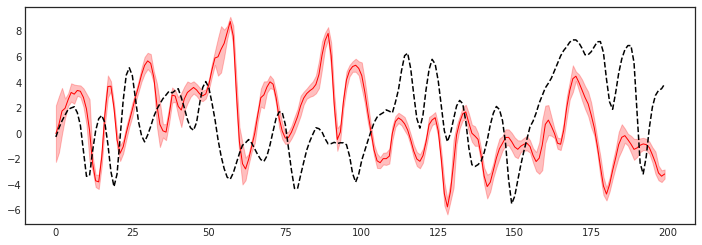

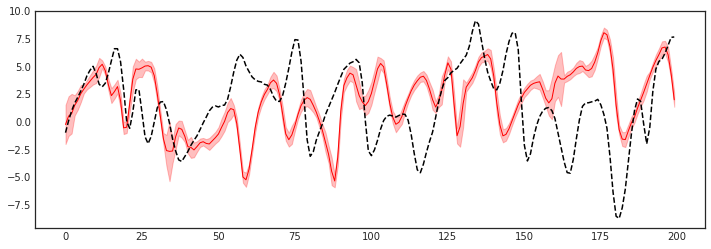

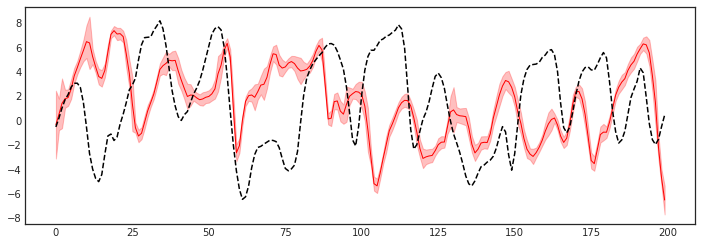

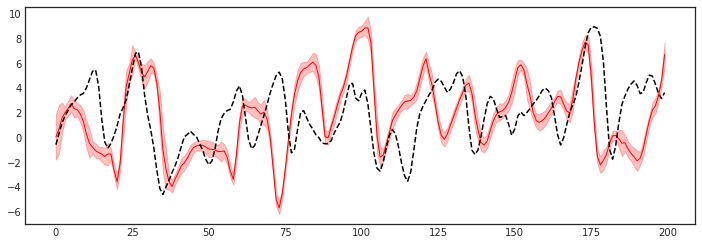

In [18]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_bspf['z_mean_seq'][:, i], 'r-', lw=1)
    _ = ax.fill_between(
        np.arange(n_steps),
        results_bspf['z_mean_seq'][:, i] - 3 * results_bspf['z_std_seq'][:, i],
        results_bspf['z_mean_seq'][:, i] + 3 * results_bspf['z_std_seq'][:, i],
        alpha=0.25, color='r'
    )
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Ensemble transform particle filter

In [19]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [20]:
%%time
results_etpf = etpf.filter(x_reference, 500, return_particles=True)

CPU times: user 1min 27s, sys: 2.57 s, total: 1min 29s
Wall time: 25.7 s


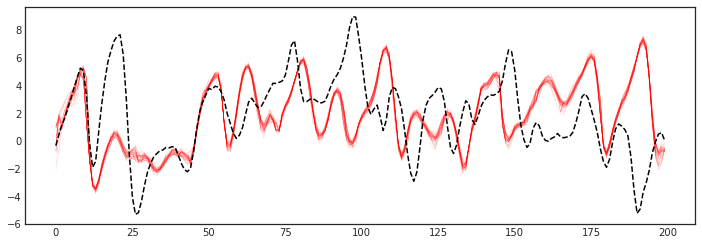

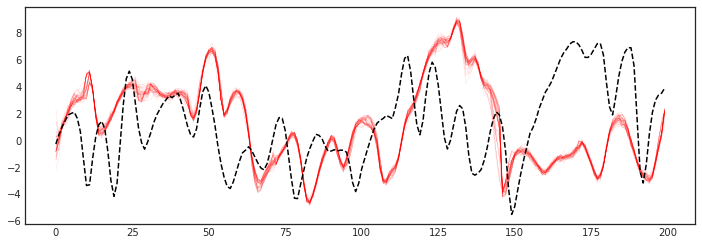

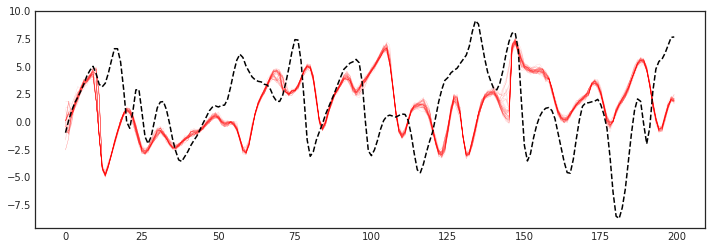

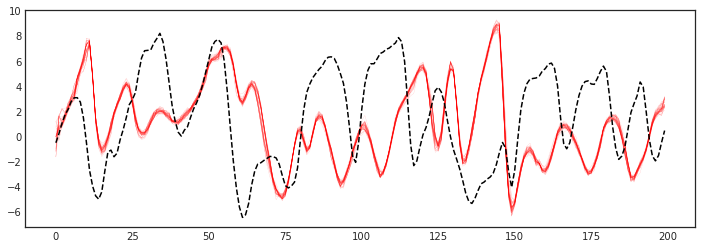

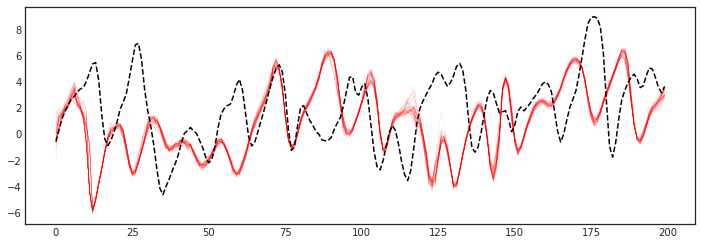

In [21]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_etpf['z_particles_seq'][:, ::10, i], 
                'r-', lw=0.25, alpha=0.25)
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

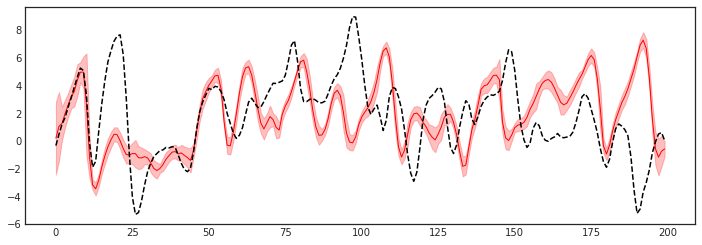

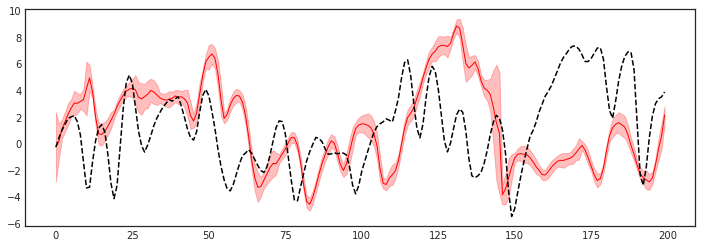

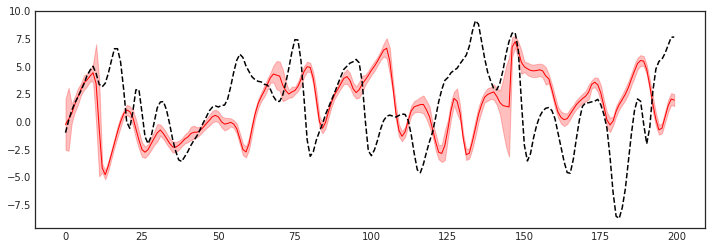

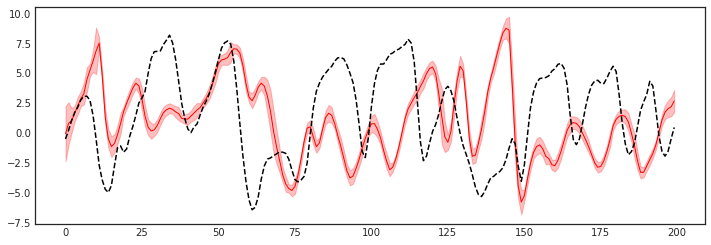

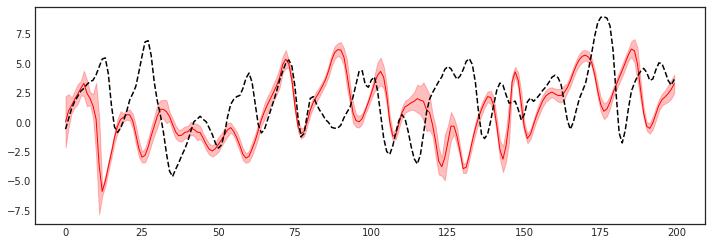

In [22]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_etpf['z_mean_seq'][:, i], 'r-', lw=1)
    _ = ax.fill_between(
        np.arange(n_steps),
        results_etpf['z_mean_seq'][:, i] - 3 * results_etpf['z_std_seq'][:, i],
        results_etpf['z_mean_seq'][:, i] + 3 * results_etpf['z_std_seq'][:, i],
        alpha=0.25, color='r'
    )
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

## Localised ensemble transform particle filter

In [23]:
state_grid_coords = np.arange(model.dim_z)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = np.arange(model.dim_z)[:, None]
localisation_radius = 4
localisation_func = da.PeriodicLocalisationFunction(
    state_grid_coords, state_grid_shape, obser_grid_coords, 
    localisation_radius, use_cache=True
)

In [24]:
letpf = da.LocalEnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_z), model.dim_z, localisation_func, 1.15, rng
)

In [25]:
%%time
results_letpf = letpf.filter(x_reference, 10, return_particles=True)

CPU times: user 11.3 s, sys: 248 ms, total: 11.6 s
Wall time: 3.82 s


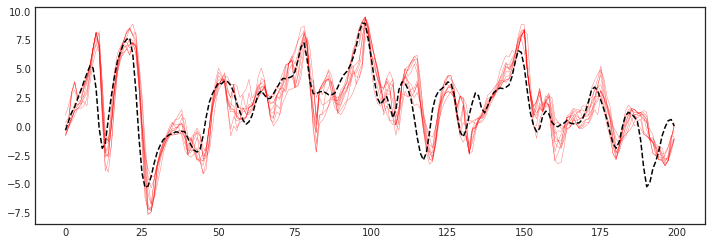

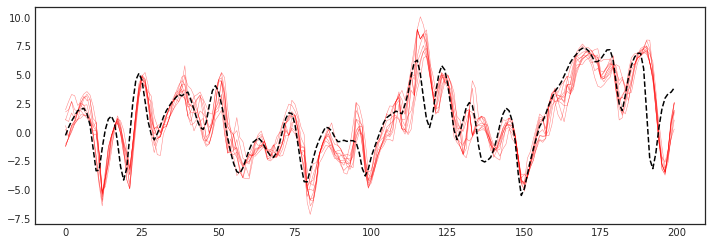

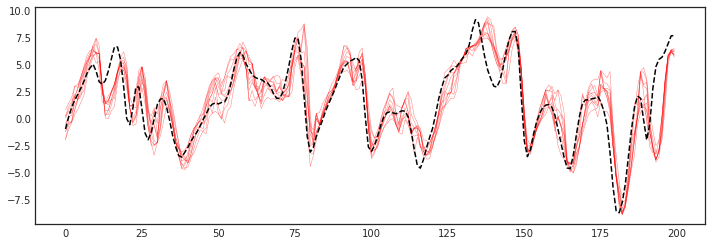

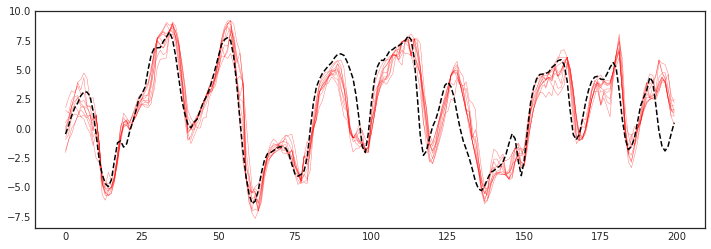

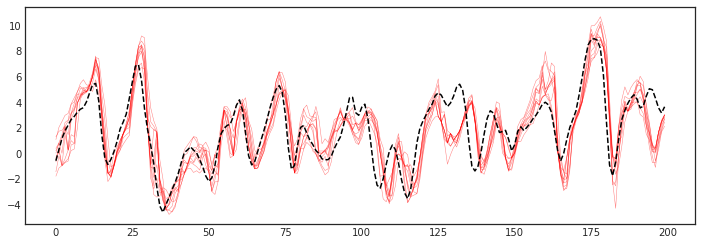

In [26]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_letpf['z_particles_seq'][:, :, i], 'r-', 
                lw=0.5, alpha=0.5)
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

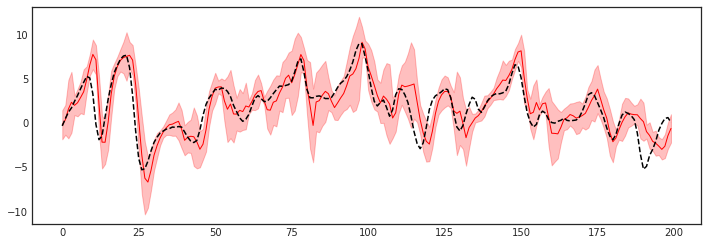

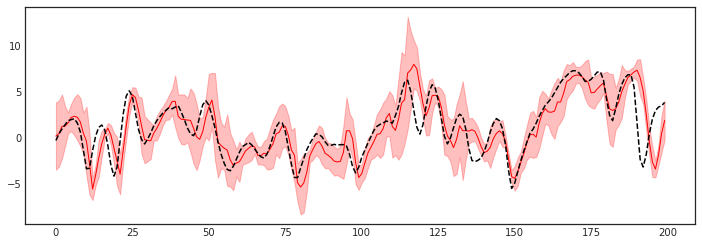

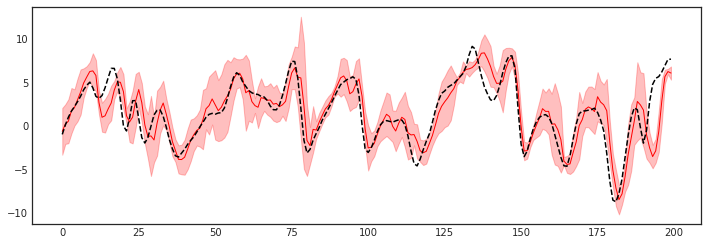

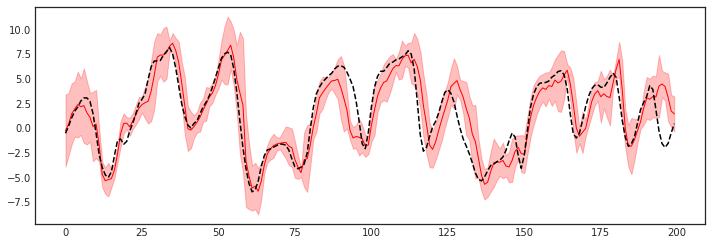

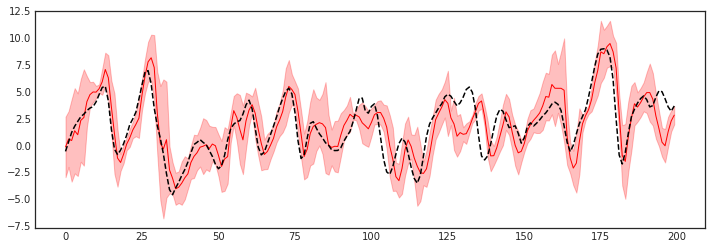

In [27]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_letpf['z_mean_seq'][:, i], 'r-', lw=1)
    _ = ax.fill_between(
        np.arange(n_steps),
        results_letpf['z_mean_seq'][:, i] - 3 * results_letpf['z_std_seq'][:, i],
        results_letpf['z_mean_seq'][:, i] + 3 * results_letpf['z_std_seq'][:, i],
        alpha=0.25, color='r'
    )
    _ = ax.plot(z_reference[:, i], 'k--', label='True')